In [ ]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: BlazingFire27
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset


100%|██████████| 788M/788M [00:08<00:00, 94.9MB/s]


In [52]:
import torch
from torch import nn
from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image, UnidentifiedImageError
import pandas as pd
import numpy as np
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [53]:
image_path = []
labels = []

for train_label in os.listdir("/content/microsoft-catsvsdogs-dataset/PetImages"):
  for train_image in os.listdir(f"/content/microsoft-catsvsdogs-dataset/PetImages/{train_label}"):
    image_path.append(f"/content/microsoft-catsvsdogs-dataset/PetImages/{train_label}/{train_image}")
    labels.append(train_label)

df = pd.DataFrame(zip(image_path, labels), columns=["image_path", "labels"])
print(df.isna().sum())
print("="*25)
print(df["labels"].unique())
print("="*25)
df.head()

image_path    0
labels        0
dtype: int64
['Cat' 'Dog']


,image_path,labels
0,/content/microsoft-catsvsdogs-dataset/PetImage...,Cat
1,/content/microsoft-catsvsdogs-dataset/PetImage...,Cat
2,/content/microsoft-catsvsdogs-dataset/PetImage...,Cat
3,/content/microsoft-catsvsdogs-dataset/PetImage...,Cat
4,/content/microsoft-catsvsdogs-dataset/PetImage...,Cat


In [54]:
#Preprocessing the data

train = df.sample(frac = 0.7)
test = df.drop(train.index)

val = test.sample(frac = 0.5)
test = test.drop(val.index)

print(train.shape)
print(val.shape)
print(test.shape)

(17501, 2)
(3750, 2)
(3751, 2)


In [55]:
label_encoder = LabelEncoder()
label_encoder.fit(df["labels"])

transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

In [56]:
class ImageDataset(Dataset):
  def __init__(self, dataframe, transform = None):
    self.dataframe = dataframe
    self.transform = transform
    self.labels = torch.tensor(label_encoder.transform(dataframe["labels"])).to(device)

  def __len__(self):
    return self.dataframe.shape[0]

  def __getitem__(self, index):
      image_path = self.dataframe.iloc[index, 0]  # specific rows, first column
      label = self.labels[index]

      try:
          image = Image.open(image_path).convert('RGB')  # Open the image and convert to RGB
      except (UnidentifiedImageError, IOError):
          print(f"Skipping invalid image: {image_path}")
          return self.__getitem__((index + 1) % len(self.dataframe))  # Skip the invalid image and move to the next one

      if self.transform:
        image = self.transform(image).to(device)

      return image, label

In [57]:
train_dataset = ImageDataset(dataframe = train, transform = transform)
val_dataset = ImageDataset(dataframe = val, transform = transform)
test_dataset = ImageDataset(dataframe = test, transform = transform)

In [58]:
print(train_dataset.__len__())
print(val_dataset.__len__())
print(test_dataset.__len__())

17501
3750
3751


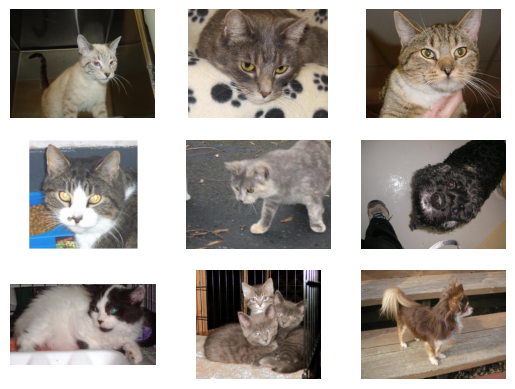

In [59]:
n_rows = 3
n_cols = 3

f, axarr = plt.subplots(n_rows, n_cols)

for row in range(n_rows):
  for cols in range(n_cols):
    image = Image.open(df.sample(n=1)["image_path"].iloc[0]).convert('RGB')
    axarr[row, cols].imshow(image)
    axarr[row, cols].axis('off')

plt.show()

In [60]:
#setting hyperparameters
LR = 1e-4
BATCH_SIZE = 16
epochs = 12

In [61]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [80]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

    self.pooling = nn.MaxPool2d(2,2)

    self.relu = nn.ReLU()

    self.flatten = nn.Flatten()
    self.linear = nn.Linear((64*16*16), 64)

    self.output = nn.Linear(64, len(df["labels"].unique()))

  def forward(self, x):
    x = self.conv1(x)
    #3x128x128 --> 16x128x128
    x = self.pooling(x)
    #16x128x128 --> 16x64x64
    x = self.relu(x)

    x = self.conv2(x)
    #16x64x64 --> 32x64x64
    x = self.pooling(x)
    #32x64x64 --> 32x32x32
    x = self.relu(x)

    x = self.conv3(x)
    #32x32x32 --> 64x32x32
    x = self.pooling(x)
    #64x32x32 --> 64x16x16
    x = self.relu(x)

    x = self.flatten(x)
    x = self.linear(x)
    x = self.output(x)

    return x

In [81]:
#model creation

model = Net().to(device)

In [82]:
#model summary

from torchsummary import summary
summary(model, input_size = (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             448
         MaxPool2d-2           [-1, 16, 64, 64]               0
              ReLU-3           [-1, 16, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]           4,640
         MaxPool2d-5           [-1, 32, 32, 32]               0
              ReLU-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          18,496
         MaxPool2d-8           [-1, 64, 16, 16]               0
              ReLU-9           [-1, 64, 16, 16]               0
          Flatten-10                [-1, 16384]               0
           Linear-11                   [-1, 64]       1,048,640
           Linear-12                    [-1, 2]             130
Total params: 1,072,354
Trainable params: 1,072,354
Non-trainable params: 0
---------------------------

In [83]:
#model params

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr = LR)

In [84]:
#training part of the model

total_loss_train_plot = []
total_loss_val_plot = []
total_acc_train_plot = []
total_acc_val_plot = []

for epoch in range(epochs):
  total_loss_train = 0
  total_acc_train = 0

  total_loss_val = 0
  total_acc_val = 0

  for inputs, labels in train_loader:
    optimizer.zero_grad()

    #finding loss
    outputs = model(inputs)
    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss

    #back prop
    train_loss.backward()
    optimizer.step()

    #finding acc
    train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
    total_acc_train += train_acc

  with torch.no_grad():
    for inputs, labels in val_loader:

      #finding loss
      outputs = model(inputs)
      val_loss = criterion(outputs, labels)
      total_loss_val += val_loss

      #finding acc
      val_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
      total_acc_val += val_acc

  total_loss_train_plot.append(round(total_loss_train.item() / 1000, 4))
  total_loss_val_plot.append(round(total_loss_val.item() / 1000, 4))

  total_acc_train_plot.append(round((total_acc_train/train_dataset.__len__())*100, 4))
  total_acc_val_plot.append(round((total_acc_val/val_dataset.__len__())*100, 4))

  print(f'''Epoch = {epoch+1}
            Train Loss = {round(total_loss_train.item() / 1000, 4)}
            Train Accuracy = {round((total_acc_train/train_dataset.__len__())*100, 4)}
            Validation Loss = {round(total_loss_val.item() / 1000, 4)}
            Validation Accuracy = {round((total_acc_val/val_dataset.__len__())*100, 4)}
        ''')
  print("="*30)

Skipping invalid image: /content/microsoft-catsvsdogs-dataset/PetImages/Cat/666.jpg
Skipping invalid image: /content/microsoft-catsvsdogs-dataset/PetImages/Cat/Thumbs.db


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch = 1
            Train Loss = 0.6814
            Train Accuracy = 64.5792
            Validation Loss = 0.135
            Validation Accuracy = 70.48
        
Skipping invalid image: /content/microsoft-catsvsdogs-dataset/PetImages/Cat/666.jpg
Skipping invalid image: /content/microsoft-catsvsdogs-dataset/PetImages/Cat/Thumbs.db
Epoch = 2
            Train Loss = 0.5902
            Train Accuracy = 73.0358
            Validation Loss = 0.1237
            Validation Accuracy = 74.1333
        
Skipping invalid image: /content/microsoft-catsvsdogs-dataset/PetImages/Cat/Thumbs.db
Skipping invalid image: /content/microsoft-catsvsdogs-dataset/PetImages/Cat/666.jpg
Epoch = 3
            Train Loss = 0.5357
            Train Accuracy = 76.4185
            Validation Loss = 0.117
            Validation Accuracy = 75.2267
        
Skipping invalid image: /content/microsoft-catsvsdogs-dataset/PetImages/Cat/Thumbs.db
Skipping invalid image: /content/microsoft-catsvsdogs-dataset/PetImages/Cat/6

In [85]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0

  for inputs, labels in test_loader:
    prediction = model(inputs)

    test_loss = criterion(prediction, labels)
    total_loss_test += test_loss

    acc = (torch.argmax(prediction, axis = 1) == labels).sum().item()
    total_acc_test += acc

print(f'''Accuracy Score= {round((total_acc_test/test_dataset.__len__())*100, 4)}
          Loss= {round(total_loss_test.item() / 1000, 4)}
      ''')

Skipping invalid image: /content/microsoft-catsvsdogs-dataset/PetImages/Dog/Thumbs.db
Skipping invalid image: /content/microsoft-catsvsdogs-dataset/PetImages/Dog/11702.jpg
Accuracy Score= 79.7121
          Loss= 0.1128
      


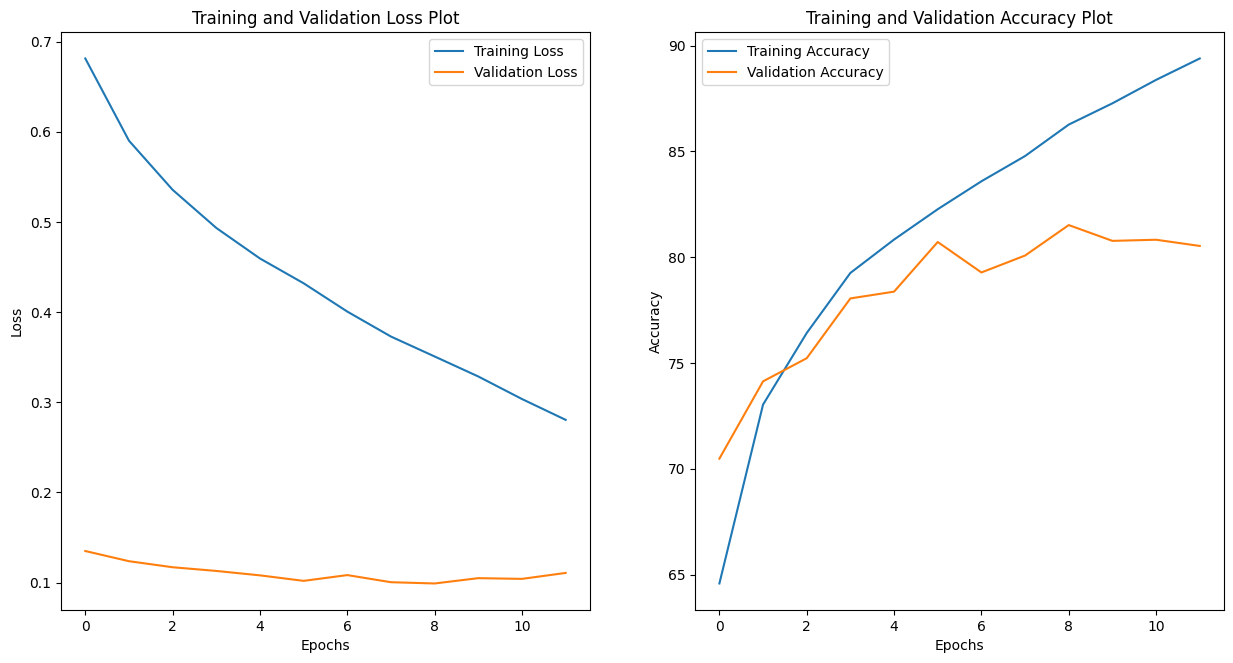

In [86]:
fig, axis = plt.subplots(nrows = 1, ncols = 2, figsize = (15,7.5))

axis[0].plot(total_loss_train_plot, label = "Training Loss")
axis[0].plot(total_loss_val_plot, label = "Validation Loss")
axis[0].set_title("Training and Validation Loss Plot")
axis[0].set_xlabel("Epochs")
axis[0].set_ylabel("Loss")
axis[0].legend()

axis[1].plot(total_acc_train_plot, label = "Training Accuracy")
axis[1].plot(total_acc_val_plot, label = "Validation Accuracy")
axis[1].set_title("Training and Validation Accuracy Plot")
axis[1].set_xlabel("Epochs")
axis[1].set_ylabel("Accuracy")
axis[1].legend()

plt.show()

In [95]:
def predict_image(image_path):
  image = Image.open(image_path).convert('RGB')
  image = transform(image).to(device)
  print(image.shape)

  output = model(image.unsqueeze(0))
  output = torch.argmax(output, axis = 1).item()
  return label_encoder.inverse_transform([output])

In [96]:
print(predict_image("/content/free_cat_image.jpg"))

torch.Size([3, 128, 128])
['Dog']
